In [1]:
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import date

In [2]:
df_interaction = pl.read_csv("../data/RAW_interactions.csv", schema_overrides={"date": pl.Date})
df_recipe = pl.read_csv("../data/RAW_recipes.csv")

In [10]:
df_interaction = pd.read_csv("../data/RAW_interactions.csv")
df_recipe = pd.read_csv("../data/RAW_recipes.csv")

In [103]:
df_interaction.head()

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [104]:
df_recipe.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [11]:
df_interaction = df_interaction.drop(df_interaction.index[df_interaction.review.isna()])
df_recipe = df_recipe.drop(df_recipe.index[(df_recipe.minutes > 60*24*365) | (df_recipe.minutes == 0)])
df_recipe = df_recipe.drop(df_recipe.index[df_recipe.n_steps == 0])
df_recipe = df_recipe.rename(columns={"id": "recipe_id"})
df_interaction.date = pd.to_datetime(df_interaction.date)
df_recipe.submitted = pd.to_datetime(df_recipe.submitted)

df_recipe_court = df_recipe[df_recipe.minutes <= 100]
df_recipe_moyen = df_recipe[(df_recipe.minutes > 100) & (df_recipe.minutes <= 60*48)]
df_recipe_long = df_recipe[df_recipe.minutes > 60*48]

In [12]:
df_total = pd.merge(df_recipe, df_interaction, on=["recipe_id"], how="inner")
df_total_court = pd.merge(df_recipe_court, df_interaction, on=["recipe_id"], how="inner")
df_total_moyen = pd.merge(df_recipe_moyen, df_interaction, on=["recipe_id"], how="inner")
df_total_long = pd.merge(df_recipe_long, df_interaction, on=["recipe_id"], how="inner")

In [107]:
minutes = np.array(sorted(df_recipe_court.minutes.unique()))
proportion_m = [0 for m in minutes]
for m in range(len(minutes)):
    comptes = df_total_court.rating[df_total_court.minutes == minutes[m]].value_counts().reindex(range(6), fill_value=0)
    proportion_m[m] = comptes[5] / comptes.sum()
proportion_m = pd.Series(np.array(proportion_m))

steps = np.array(sorted(df_recipe[df_recipe.n_steps <= 40].n_steps.unique()))
proportion_s = [0 for m in steps]
for m in range(len(steps)):
    comptes = df_total.rating[df_total.n_steps == steps[m]].value_counts().reindex(range(6), fill_value=0)
    proportion_s[m] = comptes[5] / comptes.sum()
proportion_s = pd.Series(np.array(proportion_s))

<Axes: xlabel='submitted', ylabel='Count'>

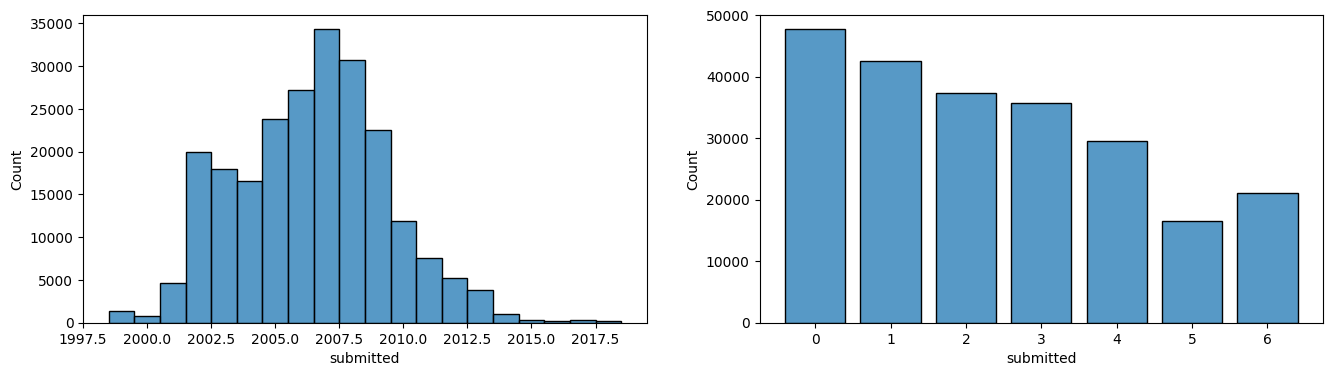

In [108]:
plt.figure(figsize=(16,4))
plt.subplot(1, 2, 1)
sns.histplot(df_recipe.submitted.dt.year, discrete=True)
plt.subplot(1, 2, 2)
sns.histplot(x=df_recipe.submitted.dt.dayofweek, discrete=True, shrink=0.8)

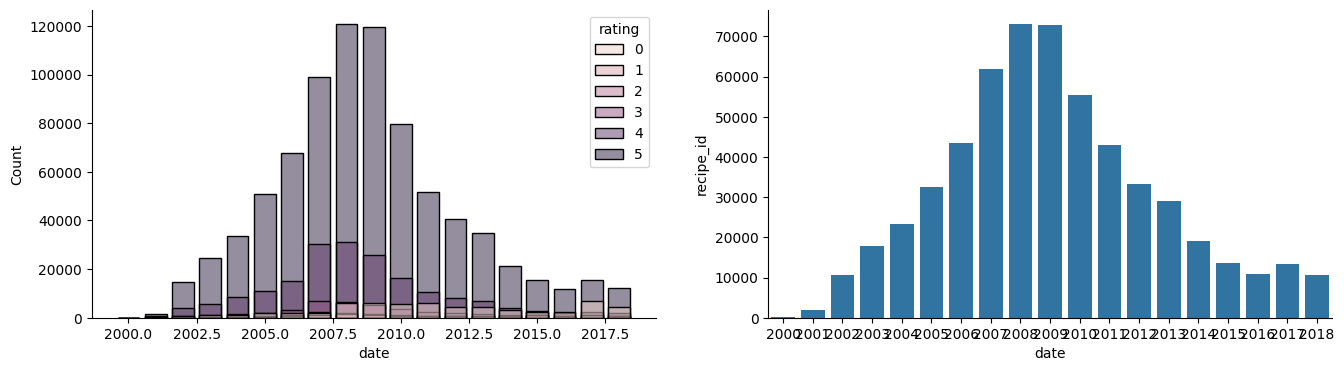

In [109]:
plt.figure(figsize=(16,4))
plt.subplot(1, 2, 1)
sns.histplot(x=df_interaction.date.dt.year, hue=df_interaction.rating, discrete=True, shrink=0.8)
plt.subplot(1, 2, 2)
sns.barplot(df_interaction.groupby(df_interaction.date.dt.year).recipe_id.nunique())
sns.despine()

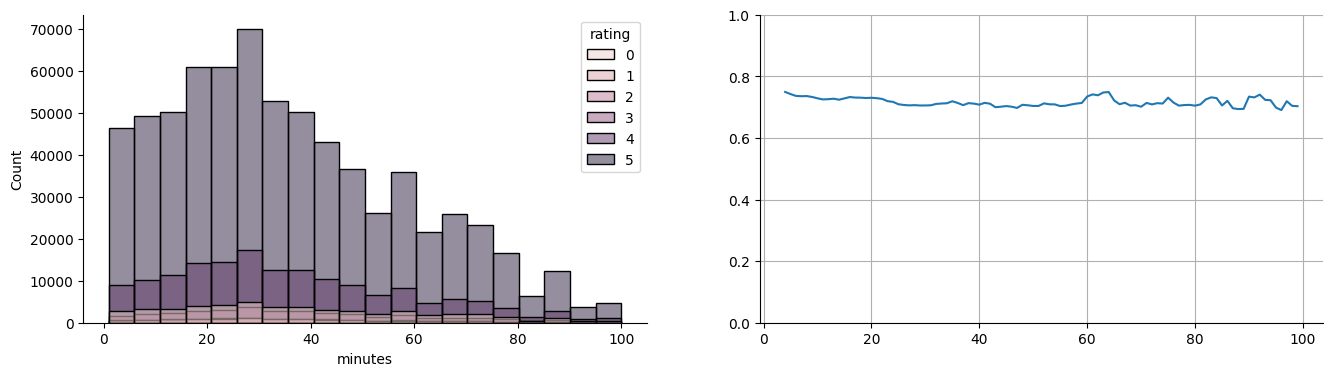

In [110]:
plt.figure(figsize=(16,4))
plt.subplot(1, 2, 1)
sns.histplot(df_total_court, x="minutes", hue="rating", bins = 20)
plt.subplot(1, 2, 2)
plt.ylim((0,1))
plt.plot(proportion_m.rolling(window=5).mean())
plt.grid()
sns.despine()

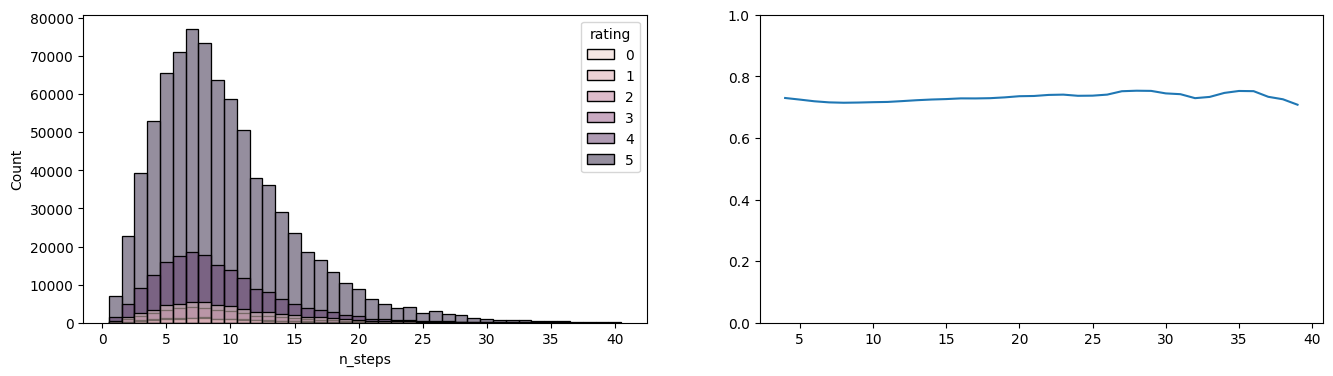

In [112]:
plt.figure(figsize=(16,4))
plt.subplot(1, 2, 1)
sns.histplot(x=df_total[df_total.n_steps <= 40].n_steps, hue=df_total.rating, discrete=True)
plt.subplot(1, 2, 2)
plt.ylim((0,1))
plt.plot(proportion_s.rolling(window=5).mean())